In [27]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime as dt
import pickle 

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [28]:
baseline_department_code = 68
input_folder        = '../output_files/processed_data'
output_parameters   = '../output_files/fitted_parameters'
output_fitted       = '../output_files/fitted_data'

In [29]:
df = pd.read_csv(f'{input_folder}/{baseline_department_code}_dominance_data.csv').replace(['0', 0], np.nan)
df['start_date'] = '2020-01-01'
df['date'] = pd.to_datetime(df['date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['days'] = (df['date'] - df['start_date']) / np.timedelta64(1, 'D')

In [30]:
mask = df['Alpha'] > 0.5
df.loc[mask, 'Alpha'] = 0

## Santander
mask = (df['days'] < 300) & (df['Otros'] < 1)
df.loc[mask, 'Otros'] = 1

mask = (df['days'] > 750)
df.loc[mask, 'Delta'] = 0

mask = (df['days'] < 750)
df.loc[mask, 'Omicron'] = 0

In [31]:
def model_func(x, rho, a, b, c, d):
    return rho * (1 / (1 + np.exp(-(a * x / 500) - b))) * (1 - (1 / (1 + np.exp(-(c * x / 500) - d))))

class ModelFunc(torch.nn.Module):
    def __init__(self, rho0: float, a0: float, b0: float, c0: float, d0: float):
        super(ModelFunc, self).__init__()    
        self.rho = torch.nn.Parameter(torch.tensor(rho0, dtype=torch.float32))
        self.a = torch.nn.Parameter(torch.tensor(a0, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b0, dtype=torch.float32))
        self.c = torch.nn.Parameter(torch.tensor(c0, dtype=torch.float32))
        self.d = torch.nn.Parameter(torch.tensor(d0, dtype=torch.float32))
    
    def forward(self, x):
        return self.rho * (1 / (1 + torch.exp(-(self.a * x / 500) - self.b))) * (1 - (1 / (1 + torch.exp(-(self.c * x / 500) - self.d))))

# Define the loss function
loss_function = torch.nn.MSELoss()


In [32]:
# Gaussian grid search parameters
num_samples = 10000
param_ranges_0 = {
    'a': (-5.4, 10),  
    'b': (16.4, 10),
    'c': (38, 10),
    'd': (-35, 10)
}

param_ranges_1 = {
    'a': (-25, 3),  
    'b': (27, 3),
    'c': (-37, 3),
    'd': (36, 3)
}

param_ranges_2 = {
    'a': (-32, 8),  
    'b': (49.0, 10),
    'c': (-37, 8),
    'd': (49, 10)
}

param_ranges_3 = {
    'a': (30, 8),  
    'b': (-46.0, 10),
    'c': (18, 8),
    'd': (-32, 10)
}

param_ranges_4 = {
    'a': (-11, 1),  
    'b': (10, 1),
    'c': (-26, 1),
    'd': (26, 1)
}

'''
Antioquia 5
param_ranges_0 = {
    'a': (-5.4, 10),  
    'b': (16.4, 10),
    'c': (38, 10),
    'd': (-35, 10)
}

param_ranges_1 = {
    'a': (-2.4, 10),  
    'b': (14.0, 10),
    'c': (-10, 10),
    'd': (20, 10)
}

param_ranges_2 = {
    'a': (-32, 8),  
    'b': (49.0, 10),
    'c': (-37, 8),
    'd': (49, 10)
}

param_ranges_3 = {
    'a': (30, 8),  
    'b': (-46.0, 10),
    'c': (18, 8),
    'd': (-32, 10)
}

param_ranges_4 = {
    'a': (-11, 1),  
    'b': (10, 1),
    'c': (-26, 1),
    'd': (26, 1)
}
 '''

'''
Bogota 11

param_ranges_0 = {
    'a': (-5.4, 10),  
    'b': (16.4, 10),
    'c': (38, 10),
    'd': (-35, 10)
}

param_ranges_1 = {
    'a': (-2.4, 10),  
    'b': (14.0, 10),
    'c': (-10, 10),
    'd': (20, 10)
}

param_ranges_2 = {
    'a': (-32, 8),  
    'b': (49.0, 10),
    'c': (-37, 8),
    'd': (49, 10)
}

param_ranges_3 = {
    'a': (30, 8),  
    'b': (-46.0, 10),
    'c': (18, 8),
    'd': (-32, 10)
}

param_ranges_4 = {
    'a': (-11, 3),  
    'b': (8, 5),
    'c': (-21, 5),
    'd': (16, 5)
}
'''

dicc_params = {}
for variant in ['Alpha', 'Delta', 'Gamma', 'Mu', 'Omicron', 'Otros']:
#for variant in ['Alpha']:
    if variant in ['Delta', 'Mu']:
        param_ranges = param_ranges_2
    elif variant in ['Omicron']:
        param_ranges = param_ranges_3
    elif variant in ['Alpha']:
        param_ranges = param_ranges_4
    elif variant in ['Otros']:
        param_ranges = param_ranges_0
    else:
        param_ranges = param_ranges_1

    # Sample initial conditions
    initial_conditions = []
    for _ in range(num_samples):
        sampled_params = {param: np.random.normal(mean, std_dev) for param, (mean, std_dev) in param_ranges.items()}
        initial_conditions.append(sampled_params)

    lowest_loss = float('inf')
    best_params = None
    for params in initial_conditions:
        # Initialize model with sampled parameters
        model = ModelFunc(1,0,0,0,0)
        model.a = torch.nn.Parameter(torch.tensor(params['a'], dtype=torch.float32))
        model.b = torch.nn.Parameter(torch.tensor(params['b'], dtype=torch.float32))
        model.c = torch.nn.Parameter(torch.tensor(params['c'], dtype=torch.float32))
        model.d = torch.nn.Parameter(torch.tensor(params['d'], dtype=torch.float32))
        
        # Compute loss
        df_ = df[~df[variant].isna()].copy()
        x_tensor = torch.tensor(df_['days'].values, dtype=torch.float32)
        y_tensor = torch.tensor(df_[variant].values, dtype=torch.float32)

        y_pred = model(x_tensor)
        loss = loss_function(y_pred, y_tensor).item()
        
        # Check if this is the best (lowest loss) set of parameters so far
        if loss < lowest_loss:
            lowest_loss = loss
            best_params = params

    # Check if best_params was set
    if best_params is not None:
        # Properly re-initialize or update model parameters
        with torch.no_grad():  # Temporarily disable gradient tracking
            model.a.data = torch.tensor(best_params['a'], dtype=torch.float32)
            model.b.data = torch.tensor(best_params['b'], dtype=torch.float32)
            model.c.data = torch.tensor(best_params['c'], dtype=torch.float32)
            model.d.data = torch.tensor(best_params['d'], dtype=torch.float32)
        print(f'{variant}')
        dicc_params[variant] = best_params.values()
    else:
        print("No suitable initial parameters were found. Check the grid search process.")

Alpha
Delta
Gamma
Mu
Omicron
Otros


In [33]:
# Gradient descent loop
variant_fits = {}
max_iterations = 1000
#for variant in ['Alpha']:
for variant in ['Alpha', 'Delta', 'Gamma', 'Mu', 'Omicron', 'Otros']:
    df_ = df[~df[variant].isna()].copy()
    x_tensor = torch.tensor(df_['days'].values, dtype=torch.float32)
    y_tensor = torch.tensor(df_[variant].values, dtype=torch.float32)

    # Initialize your model
    model = ModelFunc(1, *tuple(dicc_params[variant]))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=1)

    for _ in range(max_iterations):
        optimizer.zero_grad()  # Clear gradients from the previous step
        y_pred = model(x_tensor)  # Compute model predictions
        loss = loss_function(y_pred, y_tensor)  # Compute the loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
    
    # Store the optimized parameters for the variant
    variant_fits[variant] = [model.a.item(), model.b.item(), model.c.item(), model.d.item()]

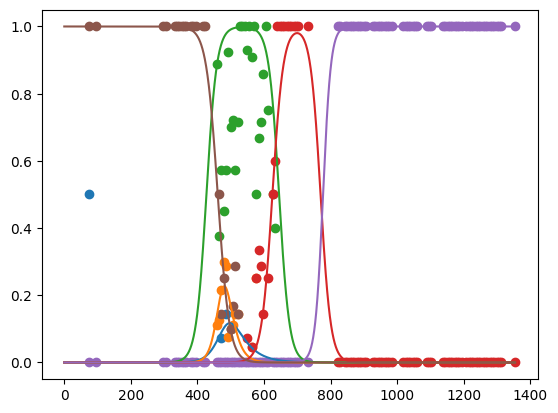

In [34]:
## plot initial fit
x_ = np.arange(0, max(df.days),0.5)
normalization = np.zeros(len(x_))
for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
#for var in ['Alpha']:
    y_1 = model_func(x_, 1, *tuple(variant_fits[var]))

    ## check normalization
    normalization += y_1

    plt.scatter(df['days'] , df[var])
    plt.plot(x_, y_1)

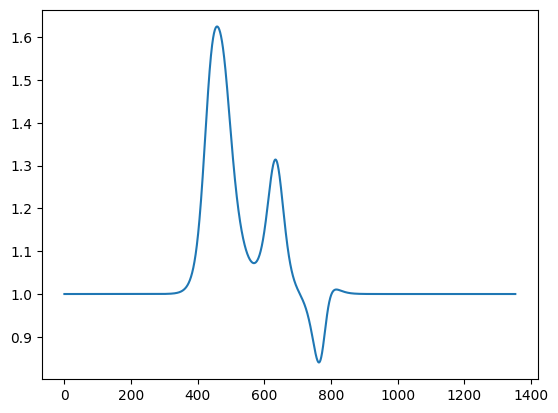

In [35]:
plt.plot(x_, normalization)

In [36]:
df_fitted = df.copy()

## get normalization
normalization = np.zeros(len(df_fitted['days']))
for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
    normalization += model_func(df_fitted['days'], 1, *tuple(variant_fits[var]))

for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
    y_1 = model_func(df_fitted['days'], 1, *tuple(variant_fits[var])) / normalization
    df_fitted[var] = y_1

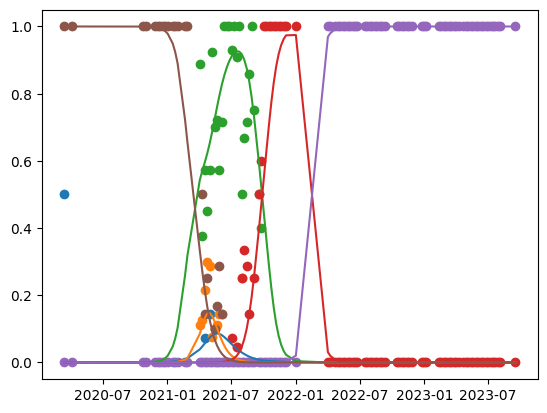

In [37]:
for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
    plt.plot(df_fitted['date'] , df_fitted[var])
    plt.scatter(df['date'] , df[var])

In [38]:
df_fitted.to_csv(f'{output_fitted}/{baseline_department_code}_dominance_data.csv', index=False)

In [39]:
save_object(variant_fits, f'{output_parameters}/{baseline_department_code}_fit_params.obj')